# Preserving global structure

In [1]:
from openTSNE import TSNE, TSNEEmbedding, affinity, initialization
from openTSNE import initialization
from openTSNE.callbacks import ErrorLogger

from examples import utils

import numpy as np

import matplotlib.pyplot as plt

## Load data

In [2]:
import gzip
import pickle

with gzip.open("data/macosko_2015.pkl.gz", "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"].astype(str)

In [3]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 44808 samples with 50 features


To avoid constantly specifying colors in our plots, define a helper here.

In [4]:
def plot(x, **kwargs):
    utils.plot(x, y, colors=utils.MACOSKO_COLORS, **kwargs)

## Easy improvements

Standard t-SNE, as implemented in most software packages, can be improved in several very easy ways that require virtually no effort in openTSNE, but can drastically improve the quality of the embedding.

### Standard t-SNE

First, we'll run t-SNE as it is implemented in most software packages. This will serve as a baseline comparison.

In [5]:
tsne = TSNE(
    perplexity=30,
    initialization="random",
    metric="euclidean",
    n_jobs=8,
    random_state=3,
)

In [6]:
%time embedding_standard = tsne.fit(x)

CPU times: user 45min 48s, sys: 54.1 s, total: 46min 42s
Wall time: 1min 37s


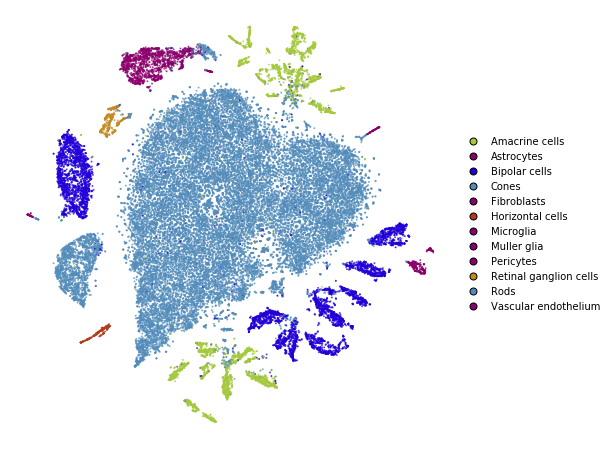

In [7]:
plot(embedding_standard)

### Using PCA initialization

The first, easy improvement we can get is to "inject" some global structure into the initialization. The intialization dictates which regions points will appear in, so adding any global structure to the initilization can help.

Note that this is the default in this implementation and the parameter can be omitted.

In [8]:
tsne = TSNE(
    perplexity=30,
    initialization="pca",
    metric="euclidean",
    n_jobs=8,
    random_state=3,
)

In [9]:
%time embedding_pca = tsne.fit(x)

CPU times: user 42min 9s, sys: 49.8 s, total: 42min 59s
Wall time: 1min 28s


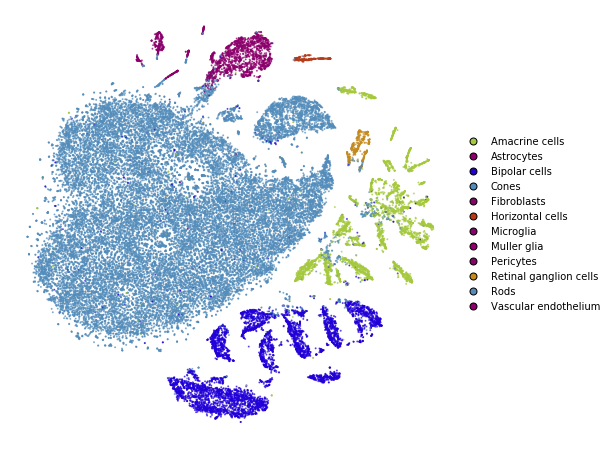

In [10]:
plot(embedding_pca)

### Using cosine distance

Typically, t-SNE is used to create an embedding of high dimensional data sets. However, the notion of *Euclidean* distance breaks down in high dimensions and the *cosine* distance is far more appropriate.

We can easily use the cosine distance by setting the `metric` parameter.

In [11]:
tsne = TSNE(
    perplexity=30,
    initialization="random",
    metric="cosine",
    n_jobs=8,
    random_state=3,
)

In [12]:
%time embedding_cosine = tsne.fit(x)

CPU times: user 46min 27s, sys: 55.8 s, total: 47min 23s
Wall time: 1min 37s


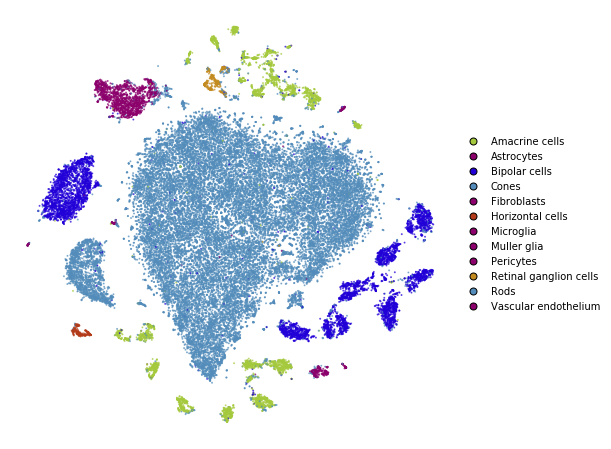

In [13]:
plot(embedding_cosine)

### Using PCA initialization and cosine distance

Lastly, let's see how our embedding looks with both the changes.

In [14]:
tsne = TSNE(
    perplexity=30,
    initialization="pca",
    metric="cosine",
    n_jobs=8,
    random_state=3,
)

In [15]:
%time embedding_pca_cosine = tsne.fit(x)

CPU times: user 44min 15s, sys: 52.6 s, total: 45min 7s
Wall time: 1min 32s


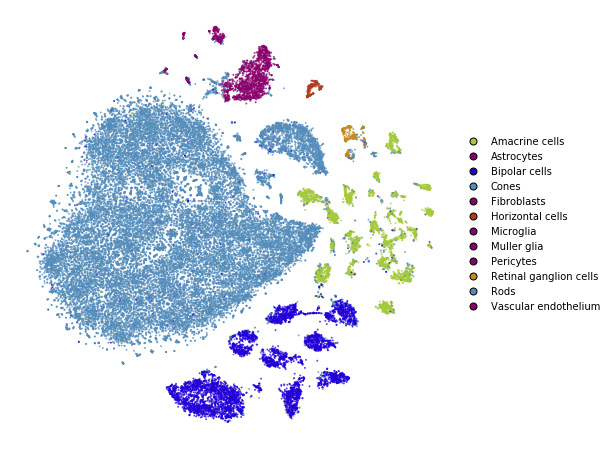

In [16]:
plot(embedding_pca_cosine)

### Summary

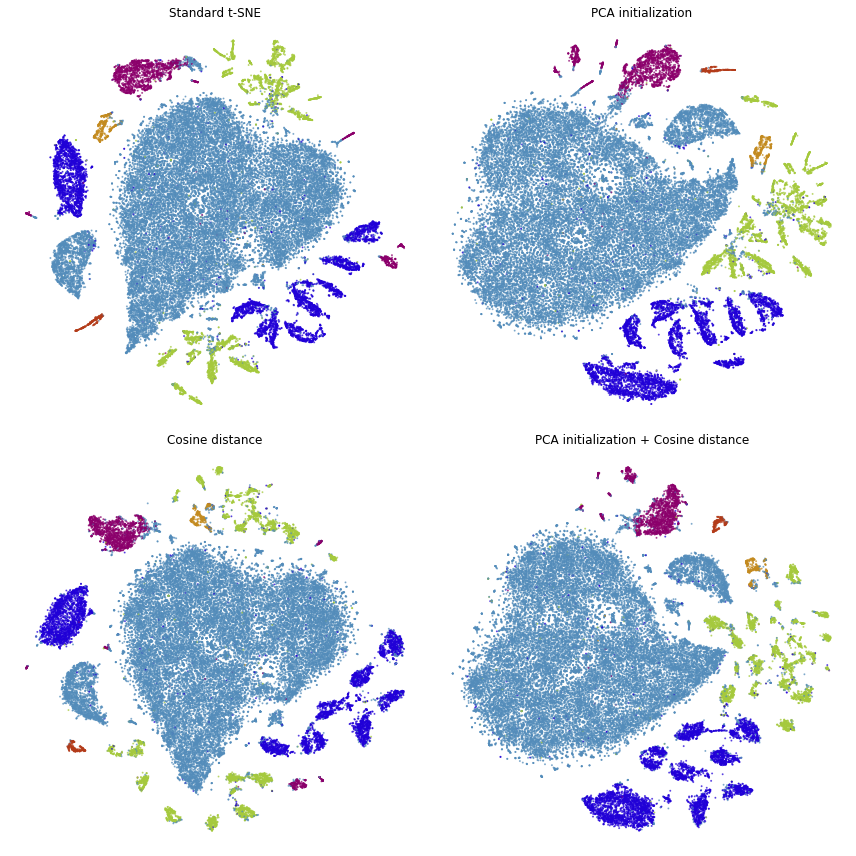

In [17]:
_, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
plot(embedding_standard, title="Standard t-SNE", ax=ax[0, 0], draw_legend=False)
plot(embedding_pca, title="PCA initialization", ax=ax[0, 1], draw_legend=False)
plot(embedding_cosine, title="Cosine distance", ax=ax[1, 0], draw_legend=False)
plot(embedding_pca_cosine, title="PCA initialization + Cosine distance", ax=ax[1, 1], draw_legend=False)
plt.tight_layout()

We can see that we've made a lot of progress already. We would like points of the same color to appear close to one another.

This is not the case in standard t-SNE and t-SNE with cosine distance, because the green points appear on both the bottom and top of the embedding and the dark blue points appear on both the left and right sides.

This is improved when using PCA initialization and better still when we use both PCA initialization and cosine distance.

## Using perplexity

Perplexity can be thought of as the trade-off parameter between preserving local and global structure. Lower values will emphasise local structure, while larger values will do a better job at preserving global structure.

### Perplexity: 30

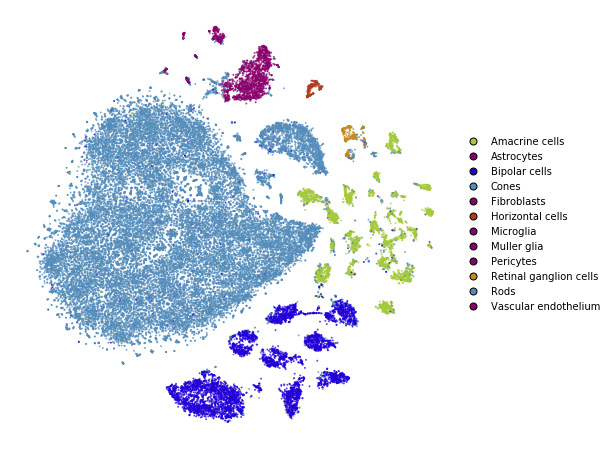

In [18]:
plot(embedding_pca_cosine)

### Perplexity: 500

In [19]:
tsne = TSNE(
    perplexity=500,
    initialization="pca",
    metric="cosine",
    n_jobs=8,
    random_state=3,
)

In [20]:
%time embedding_pca_cosine_500 = tsne.fit(x)

CPU times: user 2h 27min 38s, sys: 2min 32s, total: 2h 30min 10s
Wall time: 7min 15s


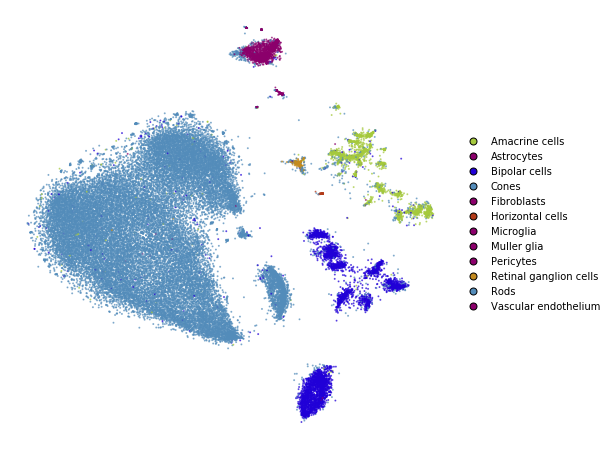

In [21]:
plot(embedding_pca_cosine_500)

## Using different affinity models

We can take advantage of the observation above, and use combinations of perplexities to obtain better embeddings.

In this section, we describe how to use the tricks described by Kobak and Berens in "The art of using t-SNE for single-cell transcriptomics". While the publication focuses on t-SNE applications to single-cell data, the methods shown here are applicable to any data set.

When dealing with large data sets, methods which compute large perplexities may be very slow. Please see the `large_data_sets` notebook for an example of how to obtain a good embedding for large data sets.

### Perplexity annealing

The first trick we can use is to first optimize the embedding using a large perplexity to capture the global structure, then lower the perplexity to something smaller to emphasize the local structure.

In [22]:
%%time
affinities_annealing = affinity.PerplexityBasedNN(
    x,
    perplexity=500,
    metric="cosine",
    n_jobs=8,
    random_state=3,
)

CPU times: user 19min 3s, sys: 16.1 s, total: 19min 19s
Wall time: 3min 51s


In [23]:
%time init = initialization.pca(x, random_state=42)

CPU times: user 3.77 s, sys: 232 ms, total: 4 s
Wall time: 100 ms


In [24]:
embedding = TSNEEmbedding(
    init,
    affinities_annealing,
    negative_gradient_method="fft",
    n_jobs=8,
)

1. Perform normal t-SNE optimization with large perplexity

In [25]:
%time embedding1 = embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5)

CPU times: user 30min 56s, sys: 35 s, total: 31min 31s
Wall time: 48.2 s


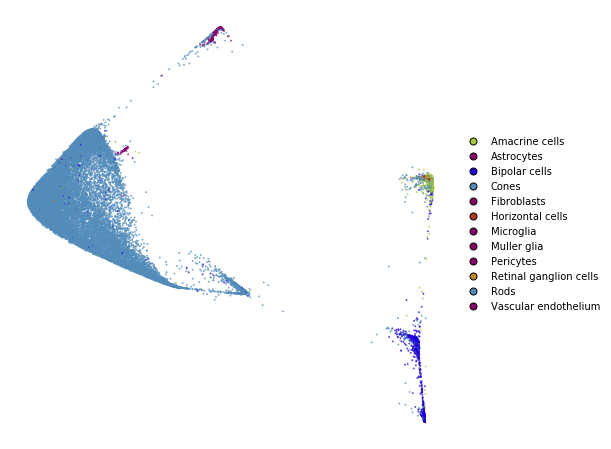

In [26]:
plot(embedding1)

In [27]:
%time embedding2 = embedding1.optimize(n_iter=750, exaggeration=1, momentum=0.8)

CPU times: user 1h 36min 47s, sys: 1min 41s, total: 1h 38min 29s
Wall time: 2min 33s


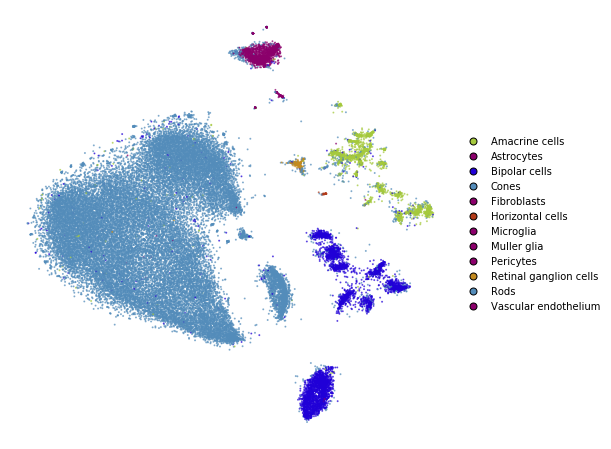

In [28]:
plot(embedding2)

2. Lower perplexity and optimize

In [29]:
%time affinities_annealing.set_perplexity(50)

CPU times: user 19.3 s, sys: 1.26 s, total: 20.6 s
Wall time: 1.54 s


In [30]:
%time embedding3 = embedding2.optimize(n_iter=500, momentum=0.8)

CPU times: user 31min 55s, sys: 39 s, total: 32min 34s
Wall time: 49.7 s


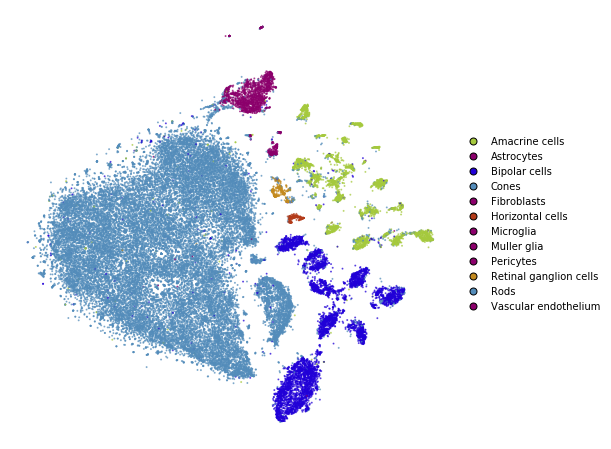

In [31]:
plot(embedding3)

In [32]:
embedding_annealing = embedding3.view(np.ndarray)

### Multiscale

One problem when using a high perplexity value e.g. 500 is that some of the clusters start to mix with each other, making the separation less apparent. Instead of a typical Gaussian kernel, we can use a multiscale kernel which will account for two different perplexity values. This typically results in better separation of clusters while still keeping much of the global structure.

In [33]:
%%time
affinities_multiscale_mixture = affinity.Multiscale(
    x,
    perplexities=[50, 500],
    metric="cosine",
    n_jobs=8,
    random_state=3,
)

CPU times: user 21min 11s, sys: 38.3 s, total: 21min 50s
Wall time: 4min 13s


In [34]:
%time init = initialization.pca(x, random_state=42)

CPU times: user 9.72 s, sys: 455 ms, total: 10.2 s
Wall time: 255 ms


In [35]:
embedding = TSNEEmbedding(
    init,
    affinities_multiscale_mixture,
    negative_gradient_method="fft",
    n_jobs=8,
)

Now, we just optimize just like we would standard t-SNE.

In [36]:
%time embedding1 = embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5)

CPU times: user 31min 24s, sys: 32.7 s, total: 31min 56s
Wall time: 48.6 s


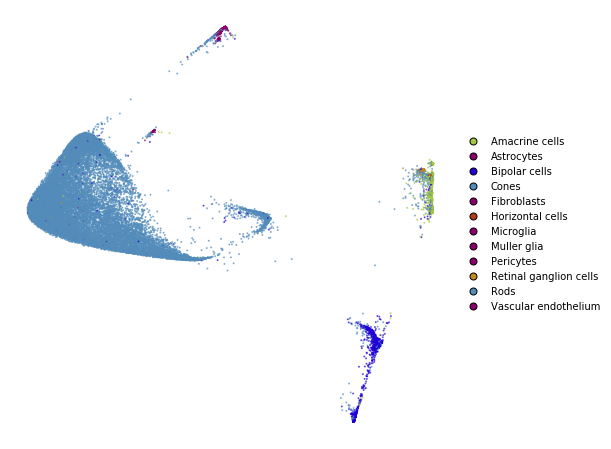

In [37]:
plot(embedding1)

In [38]:
%time embedding2 = embedding1.optimize(n_iter=750, exaggeration=1, momentum=0.8)

CPU times: user 1h 36min 12s, sys: 1min 38s, total: 1h 37min 51s
Wall time: 2min 38s


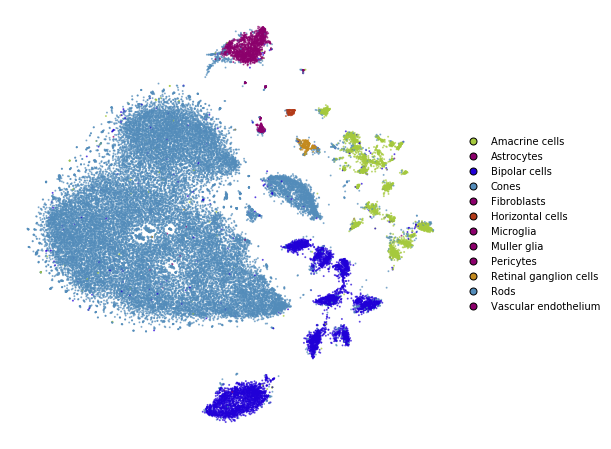

In [39]:
plot(embedding2)

In [40]:
embedding_multiscale = embedding2.view(np.ndarray)

### Summary

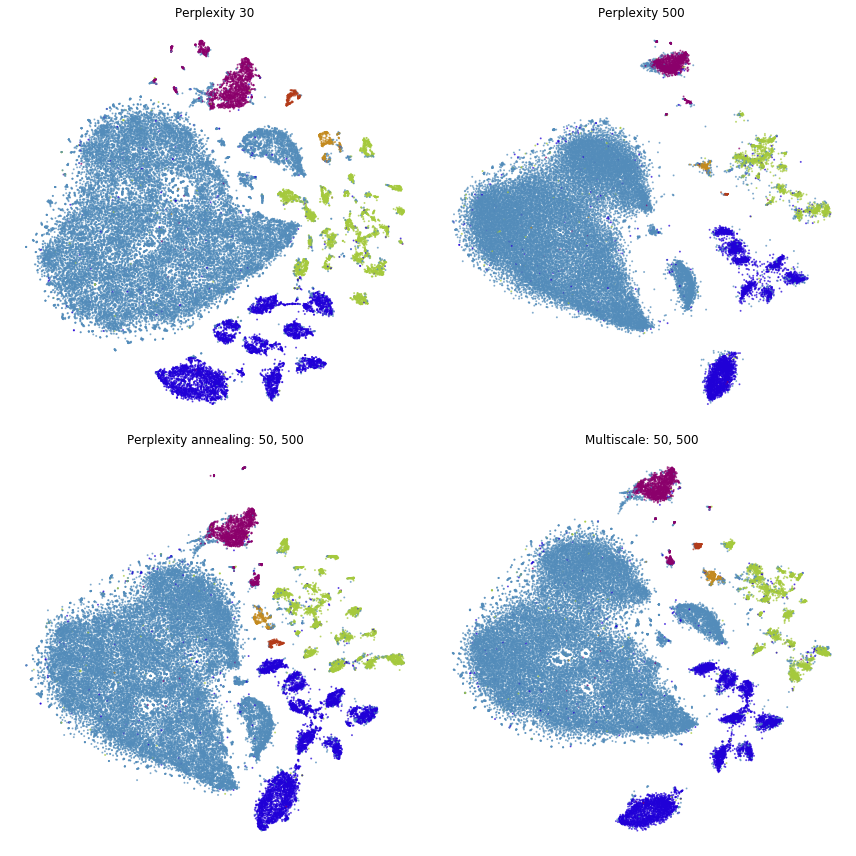

In [41]:
_, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
plot(embedding_pca_cosine, title="Perplexity 30", ax=ax[0, 0], draw_legend=False)
plot(embedding_pca_cosine_500, title="Perplexity 500", ax=ax[0, 1], draw_legend=False)
plot(embedding_annealing, title="Perplexity annealing: 50, 500", ax=ax[1, 0], draw_legend=False)
plot(embedding_multiscale, title="Multiscale: 50, 500", ax=ax[1, 1], draw_legend=False)
plt.tight_layout()

## Comparison to UMAP

In [42]:
from umap import UMAP
from itertools import product

/home/ppolicar/local/miniconda3/envs/tsne/lib/python3.7/site-packages/scikit_learn-0.21.0-py3.7-linux-x86_64.egg/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [43]:
%%time
embeddings = []

for n_neighbors, min_dist in product([15, 200], [0.1, 0.5]):
    umap = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric="cosine", random_state=3)
    embedding_umap = umap.fit_transform(x)
    embeddings.append((n_neighbors, min_dist, embedding_umap))

CPU times: user 1h 11min 8s, sys: 4min 30s, total: 1h 15min 38s
Wall time: 12min 25s


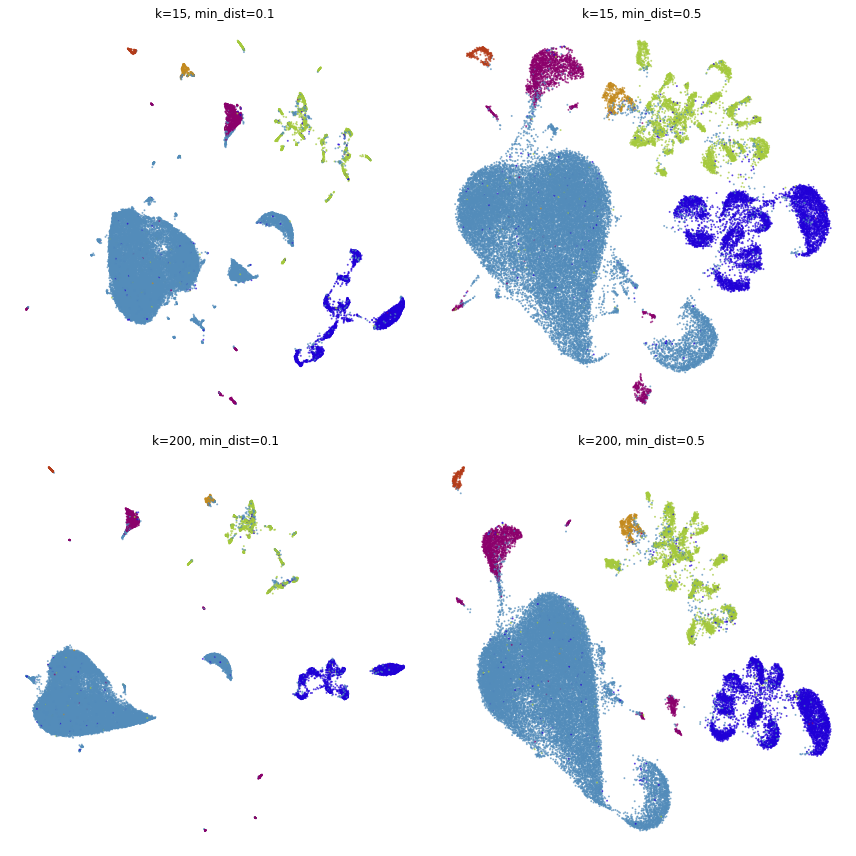

In [44]:
_, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
plot(embeddings[0][2], title=f"k={embeddings[0][0]}, min_dist={embeddings[0][1]}", ax=ax[0, 0], draw_legend=False)
plot(embeddings[1][2], title=f"k={embeddings[1][0]}, min_dist={embeddings[1][1]}", ax=ax[0, 1], draw_legend=False)
plot(embeddings[2][2], title=f"k={embeddings[2][0]}, min_dist={embeddings[2][1]}", ax=ax[1, 0], draw_legend=False)
plot(embeddings[3][2], title=f"k={embeddings[3][0]}, min_dist={embeddings[3][1]}", ax=ax[1, 1], draw_legend=False)
plt.tight_layout()